# Structural comparison of simplified O1v5-SONATA connectomes
This is an auxiliary notebook for analysing the simplified 1st..5th-order connectomes, which

 - sets up structural comparator
 - runs structural comparisom

<u>Requirements</u>: [connectome-manipulator](https://bbpgitlab.epfl.ch/conn/structural/connectome_manipulator) package (v0.0.5.dev1 or later; with v4 config format and `parallel-manipulator` entry point)

ℹ️ Related ticket: [[ACCS-49](https://bbpteam.epfl.ch/project/issues/browse/ACCS-49)] "Rewiring V5 connectome based on five simplified models of connectivity"


In [1]:
# Initialization

""" Global imports """
import json
import os

""" Local imports """
from connectome_manipulator.connectome_comparison import structural_comparator

In [19]:
def default_structcomp_config(output_path, base_name, circuit_specs):
    """Generates a default structural comparator config dict w/o any specific comparison."""
    assert isinstance(circuit_specs, list) and len(circuit_specs) == 2, 'ERROR: Two circuits required for comparison!'

    structcomp_config = {}
    structcomp_config['working_dir'] = os.path.join(output_path, base_name)
    structcomp_config['out_dir'] = structcomp_config['working_dir']
    structcomp_config['circuits'] = {str(i): {'circuit_config': circuit_specs[i]['config'],
                                              'circuit_name': circuit_specs[i]['name']} for i in range(2)}
    structcomp_config['plot_types'] = []

    return structcomp_config

def upper_first(name):
    return name[0].upper() + name[1:]

def add_ConnProb_to_config(structcomp_config, hyper_column, group_by, syn_class='EXC', skip_empty_groups=False):
    """Adds "connection probability per layer" comparison to structural comparator config."""
    assert 'plot_types' in structcomp_config, 'ERROR: Plot types missing!'
    if syn_class is None:
        cl_name = ''
        cl_sel = {}
    else:
        assert syn_class in ['EXC', 'INH'], 'ERROR: Synapse class error!'
        cl_name = syn_class[0].upper() * 2
        cl_sel = {'synapse_class': syn_class}  # Same synapse class for pre/post selection
    if hyper_column is None:
        assert group_by in ['layer', 'mtype', 'hypercolumn'], f'ERROR: Grouping by "{group_by}" not supported!'
        if len(cl_name) > 0:
            cl_name = '_' + cl_name
        name = f'ConnPer{upper_first(group_by)}{cl_name}'
        mc_sel = {}
    else:
        assert 0 <= hyper_column <= 6, 'ERROR: Hyper column out of range!'
        assert group_by in ['layer', 'mtype'], f'ERROR: Grouping by "{group_by}" not supported!'
        name = f'ConnPer{upper_first(group_by)}_mc{hyper_column}{cl_name}'
        mc_sel = {'hypercolumn': hyper_column}
    comp_dict = {'name': name,
                 'fct': {'source': 'connectivity',
                         'kwargs': {'group_by': group_by,
                                    'skip_empty_groups': skip_empty_groups,
                                    'sel_src': {**mc_sel, **cl_sel},
                                    'sel_dest': {**mc_sel, **cl_sel}}},
                         'res_sel': ['nsyn_conn', 'conn_prob'],
                         'range_prctile': 100,
                         'fig_size': (11, 3),
                         'fig_file': {'format': 'png', 'dpi': 600}}
    structcomp_config['plot_types'].append(comp_dict)

def add_MeanProps_to_config(structcomp_config, hyper_column, props_list, group_by, skip_empty_groups=False):
    """Adds "connection properties (mean) per layer" comparison to structural comparator config."""
    assert 'plot_types' in structcomp_config, 'ERROR: Plot types missing!'
    assert 0 <= hyper_column <= 6, 'ERROR: Hyper column out of range!'
    assert isinstance(props_list, list) and len(props_list) > 0, "ERROR: Non-empty list of properties required!"
    assert group_by in ['layer', 'mtype'], f'ERROR: Grouping by "{group_by}" not supported!'
    comp_dict = {'name': f'PropsPer{upper_first(group_by)}_mc{hyper_column}EE',
                         'fct': {'source': 'properties',
                                 'kwargs': {'group_by': group_by,
                                            'skip_empty_groups': skip_empty_groups,
                                            'sel_src': {'hypercolumn': hyper_column, 'synapse_class': 'EXC'},
                                            'sel_dest': {'hypercolumn': hyper_column, 'synapse_class': 'EXC'},
                                            'fct': 'np.mean'}},
                                 'res_sel': props_list,
                                 'range_prctile': 100,
                                 'fig_size': (11, 3),
                                 'fig_file': {'format': 'png', 'dpi': 600}}
    structcomp_config['plot_types'].append(comp_dict)

def add_AdjMat_to_config(structcomp_config, hyper_column):
    """Adds "adjacency matrix" comparison to structural comparator config."""
    assert 'plot_types' in structcomp_config, 'ERROR: Plot types missing!'
    assert 0 <= hyper_column <= 6, 'ERROR: Hyper column out of range!'
    comp_dict = {'name': f'Adjacency_mc{hyper_column}EE',
                         'fct': {'source': 'adjacency',
                                 'kwargs': {'sel_src': {'hypercolumn': hyper_column, 'synapse_class': 'EXC'},
                                            'sel_dest': {'hypercolumn': hyper_column, 'synapse_class': 'EXC'}}},
                                 'res_sel': ['adj', 'adj_cnt'],
                                 'range_prctile': 95,
                                 'fig_size': (11, 3),
                                 'fig_file': {'format': 'png', 'dpi': 600}}
    structcomp_config['plot_types'].append(comp_dict)

def export_structcomp_config(structcomp_config, config_path):
    """Writes structural comparator config to .json config file(s)."""
    if not isinstance(config_path, list):
        config_path = [config_path]

    base_name = os.path.split(structcomp_config['working_dir'])[-1]
    fn = f'structcomp_config__{base_name}__{structcomp_config["circuits"]["0"]["circuit_name"]}_vs_{structcomp_config["circuits"]["1"]["circuit_name"]}.json'
    for cpath in config_path:
        with open(os.path.join(cpath, fn), 'w') as f:
            json.dump(structcomp_config, f, indent=2)
        print(f"Config file {fn} written to {cpath}")

### Selection of circuits to compare

In [3]:
# Circuit base name
circuit_name_base = 'O1v5-SONATA'

# Original circuit
circuit_name_orig = 'Orig'
circuit_config_orig = f'/gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/{circuit_name_base}/sonata/circuit_config_tmp.json' # SONATA config (.json)  # TEMP edges file with afferent_center_x/y/z properties preliminarily added w/o validation, see [NSETM-1222]
circuit_spec_orig = {'name': circuit_name_orig, 'config': circuit_config_orig}

# Simplified circuits
order_list = list(range(1, 4))  # list(range(1, 6))
circuit_names_manip = [f'Order-{_ord}' for _ord in order_list]
circuit_configs_manip = [f'/gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/{circuit_name_base}__ConnRewireOrder{_ord}mc2EE100pct/circuit_config.json' for _ord in order_list]
circuit_specs_manip = [{'name': nm, 'config': cfg} for nm, cfg in zip(circuit_names_manip, circuit_configs_manip)]

### Configuration of structural comparison

In [4]:
# Output paths
output_path = '/gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison'
config_paths = ['../configs', '/gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/configs']  # Write to local and proj9 folder

# Selection of column
hyper_column = 2  # 2...central column

# Selection of properties to compare
props_list = ['conductance', 'decay_time', 'delay', 'depression_time', 'facilitation_time', 'syn_type_id', 'u_syn']

In [19]:
# Structural comparison of original vs. simplified connectomes
for idx in range(len(order_list)):
    structcomp_config = default_structcomp_config(output_path, circuit_name_base, [circuit_spec_orig, circuit_specs_manip[idx]])
    add_ConnProb_to_config(structcomp_config, hyper_column, group_by='layer', skip_empty_groups=False)
    add_ConnProb_to_config(structcomp_config, hyper_column, group_by='mtype', skip_empty_groups=True)
    add_MeanProps_to_config(structcomp_config, hyper_column, props_list=props_list, group_by='layer', skip_empty_groups=False)
    add_MeanProps_to_config(structcomp_config, hyper_column, props_list=props_list, group_by='mtype', skip_empty_groups=True)
    add_AdjMat_to_config(structcomp_config, hyper_column)
    export_structcomp_config(structcomp_config, config_paths)

Config file structcomp_config__O1v5-SONATA__Orig_vs_Order-1.json written to ../configs
Config file structcomp_config__O1v5-SONATA__Orig_vs_Order-1.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/configs
Config file structcomp_config__O1v5-SONATA__Orig_vs_Order-2.json written to ../configs
Config file structcomp_config__O1v5-SONATA__Orig_vs_Order-2.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/configs
Config file structcomp_config__O1v5-SONATA__Orig_vs_Order-3.json written to ../configs
Config file structcomp_config__O1v5-SONATA__Orig_vs_Order-3.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/configs


In [16]:
# One validation run (1st order only) over all hypercolumns
structcomp_config = default_structcomp_config(output_path, circuit_name_base + "__AllMCs", [circuit_spec_orig, circuit_specs_manip[0]])
add_ConnProb_to_config(structcomp_config, hyper_column=None, group_by='hypercolumn', skip_empty_groups=False)
export_structcomp_config(structcomp_config, config_paths)

Config file structcomp_config__O1v5-SONATA__AllMCs__Orig_vs_Order-1.json written to ../configs
Config file structcomp_config__O1v5-SONATA__AllMCs__Orig_vs_Order-1.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/configs


In [23]:
# One validation run (1st order only) with EXC + INH m-types
structcomp_config = default_structcomp_config(output_path, circuit_name_base + "__AllMtypes", [circuit_spec_orig, circuit_specs_manip[0]])
add_ConnProb_to_config(structcomp_config, hyper_column=hyper_column, syn_class=None, group_by='mtype', skip_empty_groups=False)
export_structcomp_config(structcomp_config, config_paths)

Config file structcomp_config__O1v5-SONATA__AllMtypes__Orig_vs_Order-1.json written to ../configs
Config file structcomp_config__O1v5-SONATA__AllMtypes__Orig_vs_Order-1.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/configs


### Run structural comparison

In [5]:
def load_config_from_file(path, fn):
    config_file = os.path.join(path, fn)
    with open(config_file, 'r') as f:
        structcomp_config = json.load(f)
    return structcomp_config

INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA/sonata/circuit_config_tmp.json
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA__ConnRewireOrder1mc2EE100pct/circuit_config.json
INFO: Preparing "ConnPerLayer_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_ConnPerLayer_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-1_ConnPerLayer_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-1/struct_comp-ConnPerLayer_mc2EE-nsyn_conn.png...


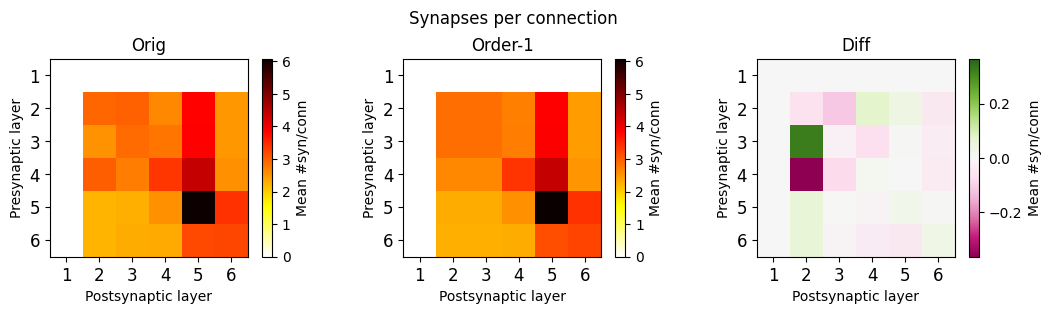

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-1/struct_comp-ConnPerLayer_mc2EE-conn_prob.png...


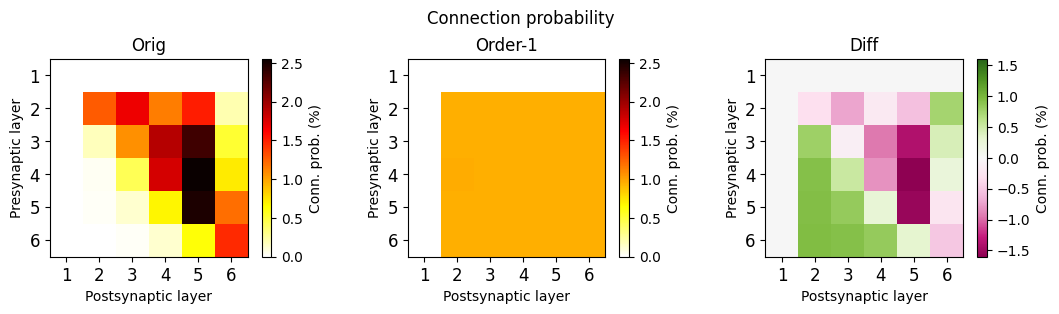

INFO: Preparing "ConnPerMtype_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_ConnPerMtype_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-1_ConnPerMtype_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-1/struct_comp-ConnPerMtype_mc2EE-nsyn_conn.png...


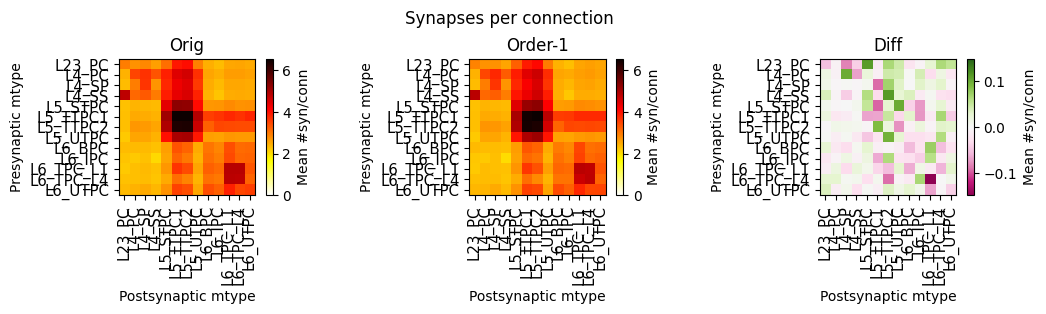

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-1/struct_comp-ConnPerMtype_mc2EE-conn_prob.png...


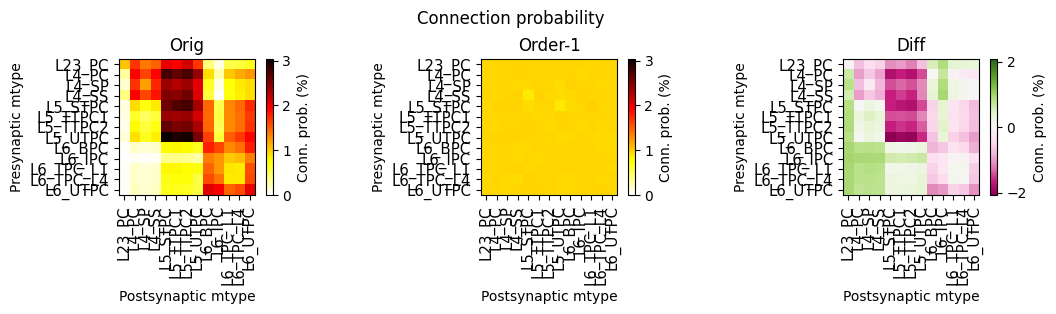

INFO: Preparing "PropsPerLayer_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_PropsPerLayer_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-1_PropsPerLayer_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-1/struct_comp-PropsPerLayer_mc2EE-conductance.png...


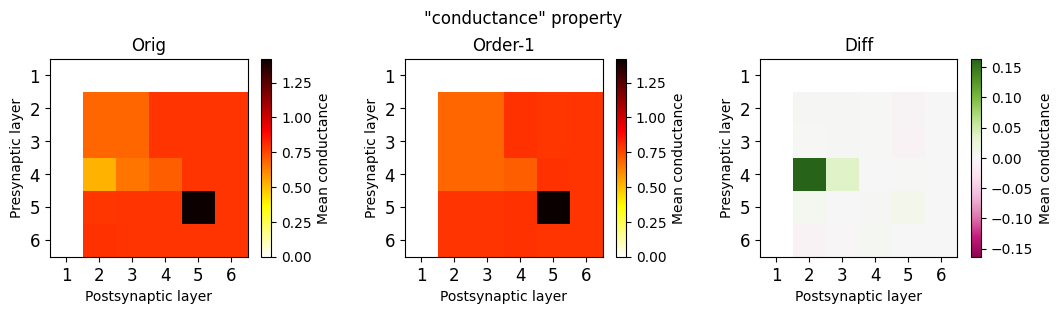

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-1/struct_comp-PropsPerLayer_mc2EE-delay.png...


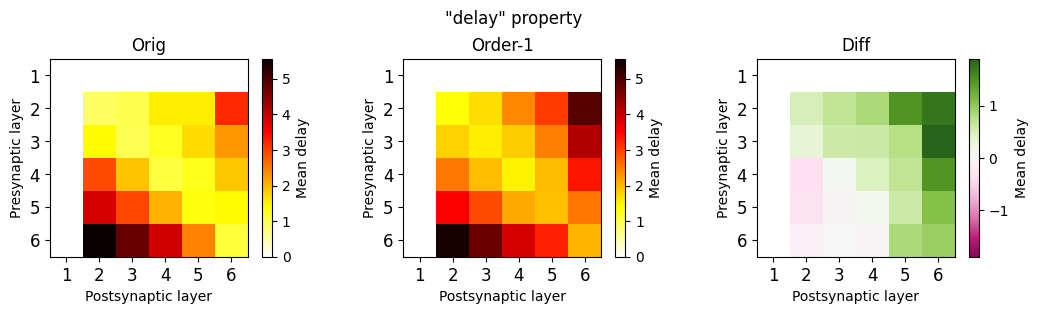

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-1/struct_comp-PropsPerLayer_mc2EE-u_syn.png...


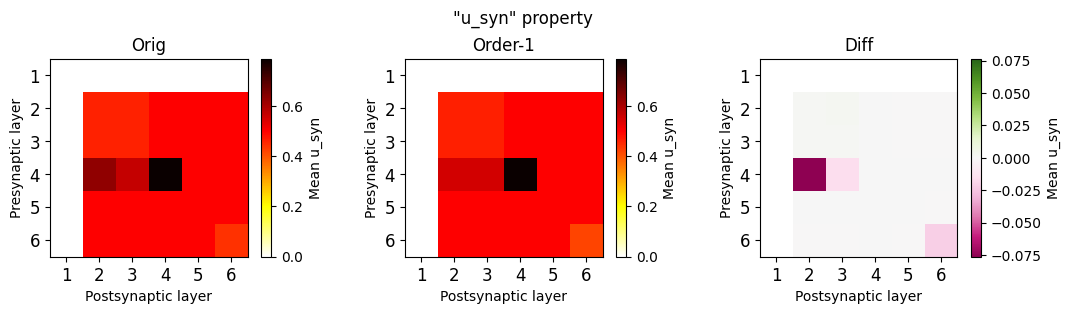

INFO: Preparing "PropsPerMtype_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_PropsPerMtype_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-1_PropsPerMtype_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-1/struct_comp-PropsPerMtype_mc2EE-conductance.png...


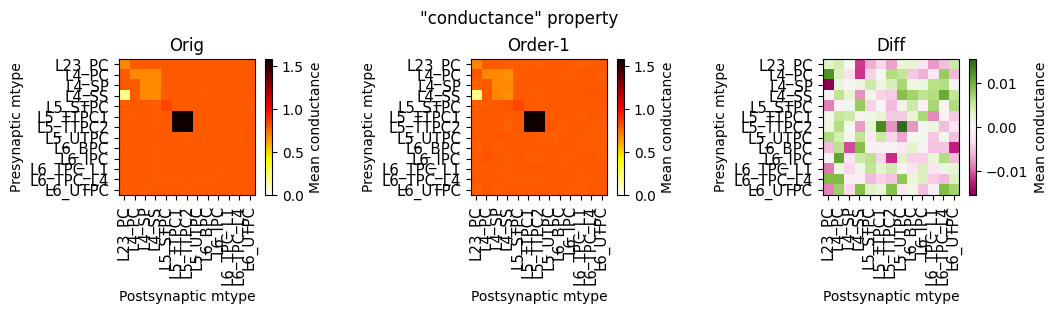

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-1/struct_comp-PropsPerMtype_mc2EE-delay.png...


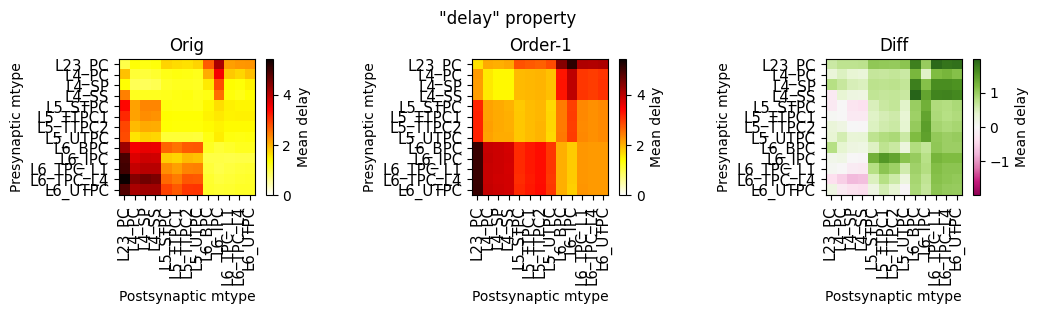

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-1/struct_comp-PropsPerMtype_mc2EE-u_syn.png...


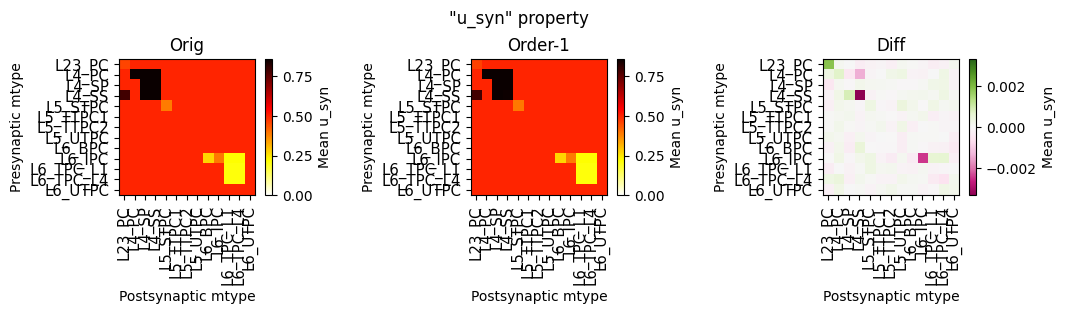

INFO: Preparing "Adjacency_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_Adjacency_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-1_Adjacency_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-1/struct_comp-Adjacency_mc2EE-adj.png...


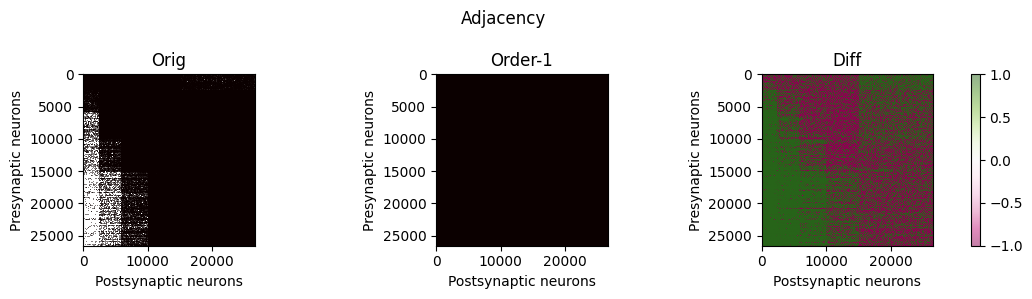

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-1/struct_comp-Adjacency_mc2EE-adj_cnt.png...


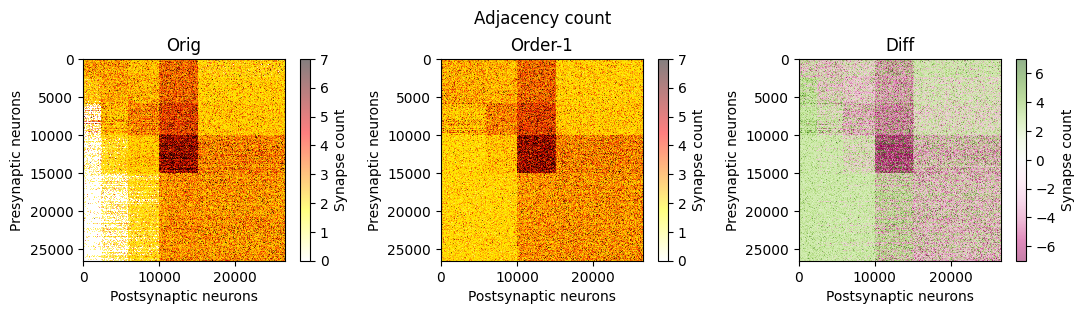

In [6]:
# Load config & run 1st-order comparison
structcomp_config = load_config_from_file(config_paths[-1], 'structcomp_config__O1v5-SONATA__Orig_vs_Order-1.json')
structural_comparator.main(structcomp_config, show_fig=True, force_recomp=[False, False])

INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA/sonata/circuit_config_tmp.json
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA__ConnRewireOrder2mc2EE100pct/circuit_config.json
INFO: Preparing "ConnPerLayer_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_ConnPerLayer_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-2_ConnPerLayer_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-2/struct_comp-ConnPerLayer_mc2EE-nsyn_conn.png...


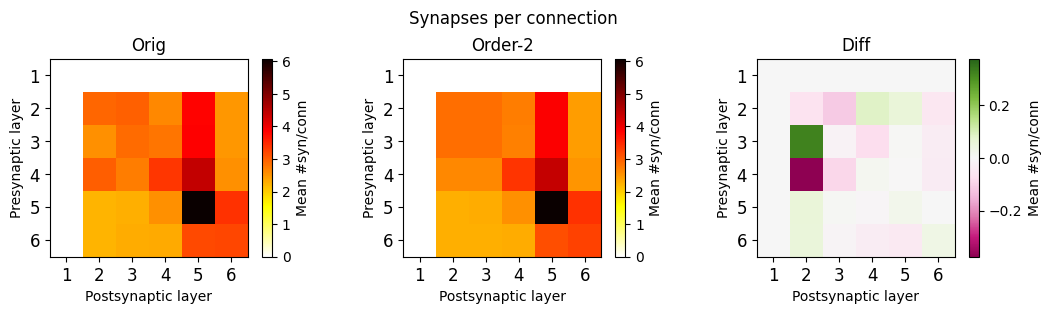

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-2/struct_comp-ConnPerLayer_mc2EE-conn_prob.png...


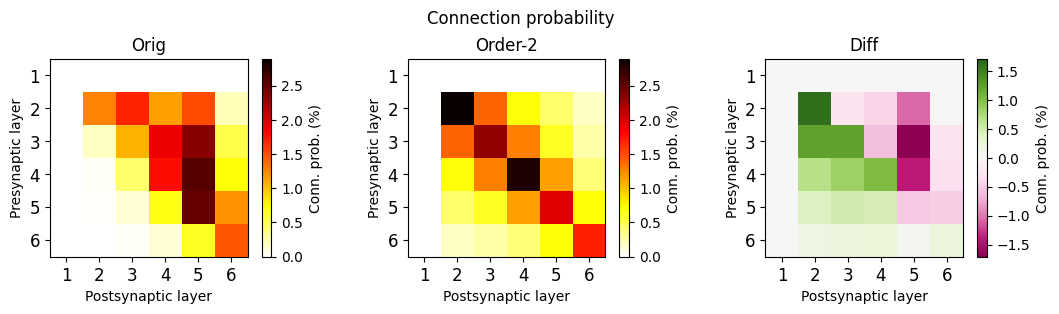

INFO: Preparing "ConnPerMtype_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_ConnPerMtype_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-2_ConnPerMtype_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-2/struct_comp-ConnPerMtype_mc2EE-nsyn_conn.png...


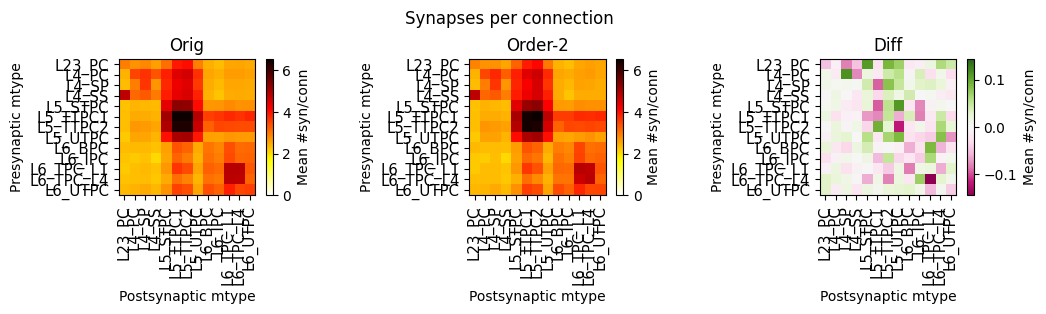

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-2/struct_comp-ConnPerMtype_mc2EE-conn_prob.png...


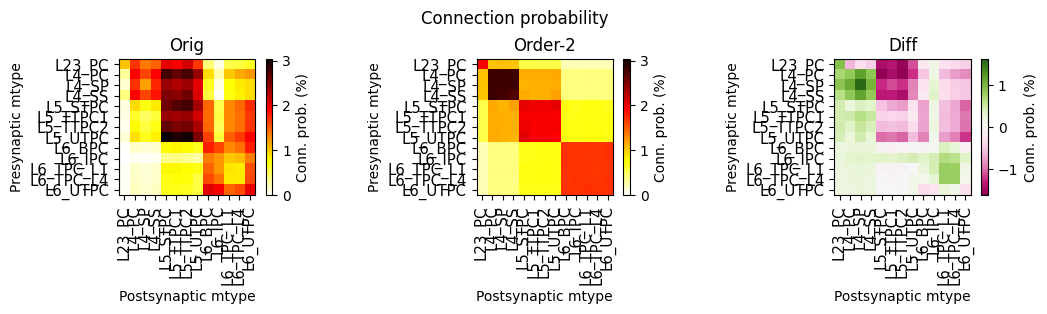

INFO: Preparing "PropsPerLayer_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_PropsPerLayer_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-2_PropsPerLayer_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-2/struct_comp-PropsPerLayer_mc2EE-conductance.png...


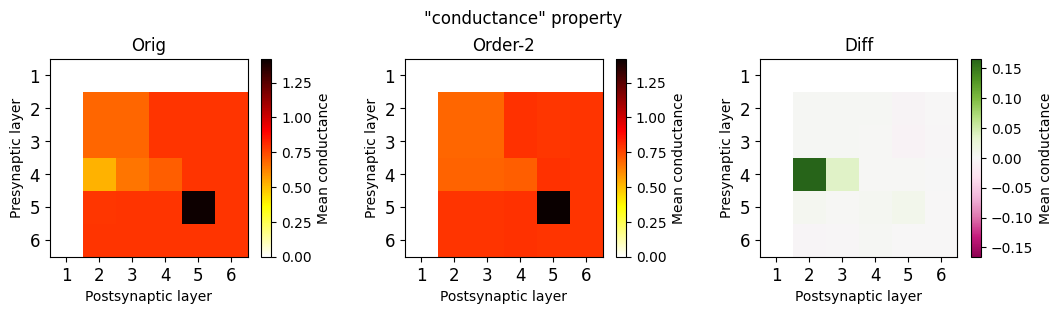

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-2/struct_comp-PropsPerLayer_mc2EE-delay.png...


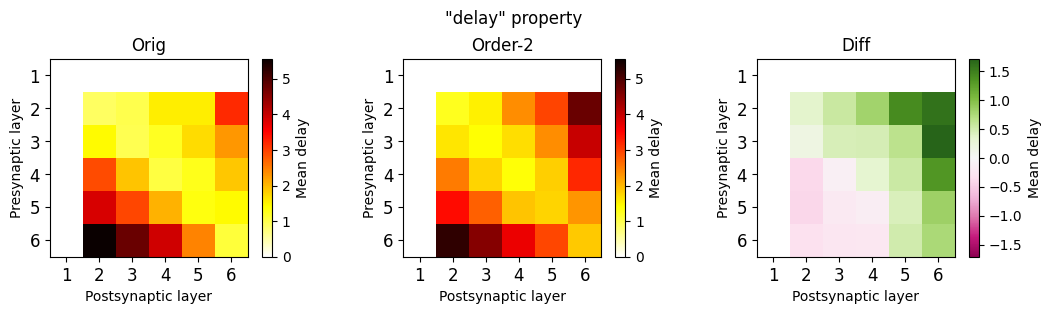

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-2/struct_comp-PropsPerLayer_mc2EE-u_syn.png...


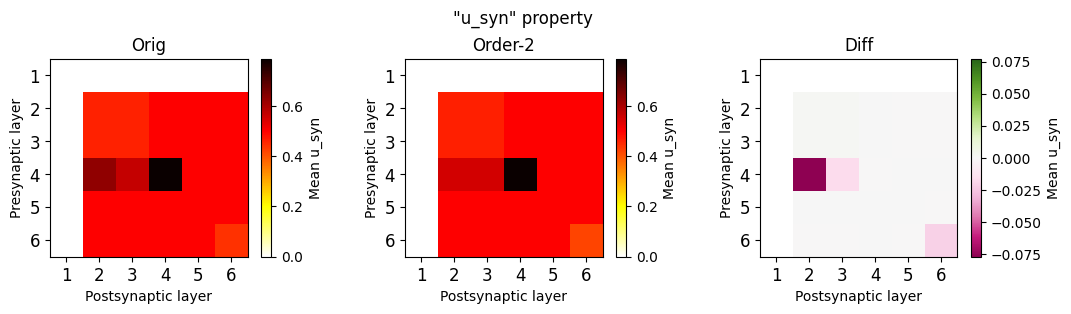

INFO: Preparing "PropsPerMtype_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_PropsPerMtype_mc2EE.pickle
INFO: Extracting synapse properties (group_by=mtype, sel_src={'hypercolumn': 2, 'synapse_class': 'EXC'}, sel_dest={'hypercolumn': 2, 'synapse_class': 'EXC'}, N=13x13 groups, per_conn=False)
INFO: Available synapse properties: 
['@source_node', '@target_node', 'absolute_efficacy', 'afferent_center_x', 'afferent_center_y', 'afferent_center_z', 'afferent_section_id', 'afferent_section_type', 'afferent_segment_id', 'afferent_segment_offset', 'conductance', 'decay_time', 'delay', 'depression_time', 'efferent_morphology_id', 'efferent_section_id', 'efferent_segment_id', 'efferent_segment_offset', 'facilitation_time', 'morpho_branch_order_axon', 'morpho_branch_order_dend', 'n_rrp_vesicles', 'nrn_line', 'syn_type_id', 'u_syn']


100% |########################################################################|


INFO: Writing resutls to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-2_PropsPerMtype_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-2/struct_comp-PropsPerMtype_mc2EE-conductance.png...


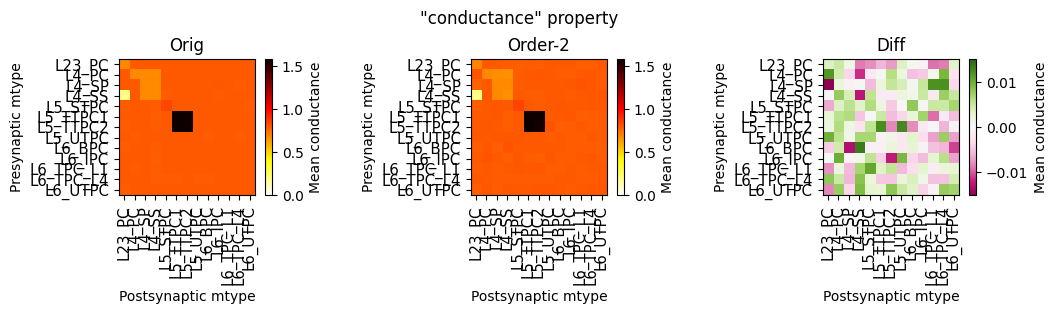

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-2/struct_comp-PropsPerMtype_mc2EE-delay.png...


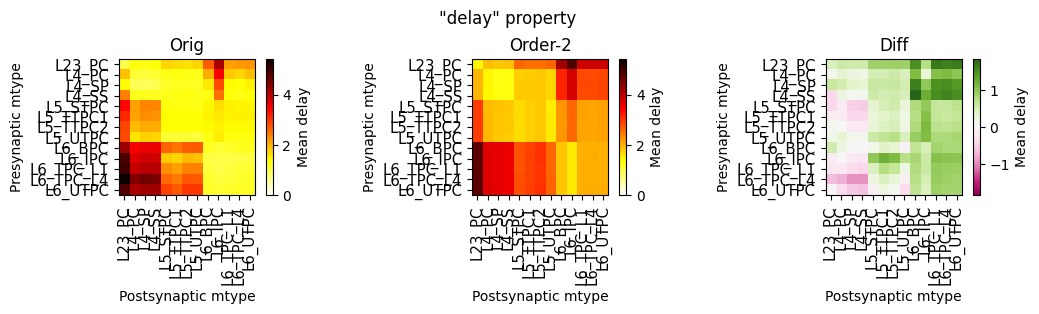

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-2/struct_comp-PropsPerMtype_mc2EE-u_syn.png...


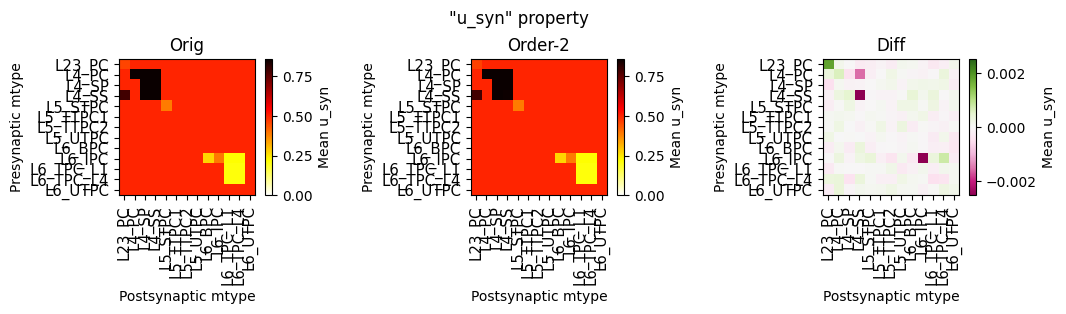

INFO: Preparing "Adjacency_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_Adjacency_mc2EE.pickle
INFO: Creating 26567x26567 adjacency matrix (sel_src={'hypercolumn': 2, 'synapse_class': 'EXC'}, sel_dest={'hypercolumn': 2, 'synapse_class': 'EXC'})
INFO: Writing resutls to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-2_Adjacency_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-2/struct_comp-Adjacency_mc2EE-adj.png...


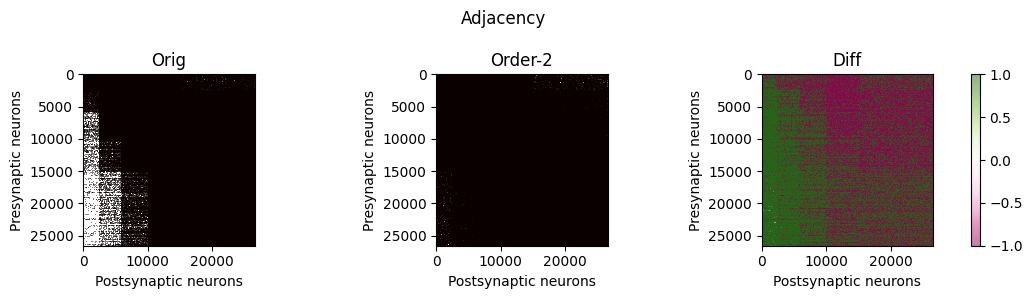

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-2/struct_comp-Adjacency_mc2EE-adj_cnt.png...


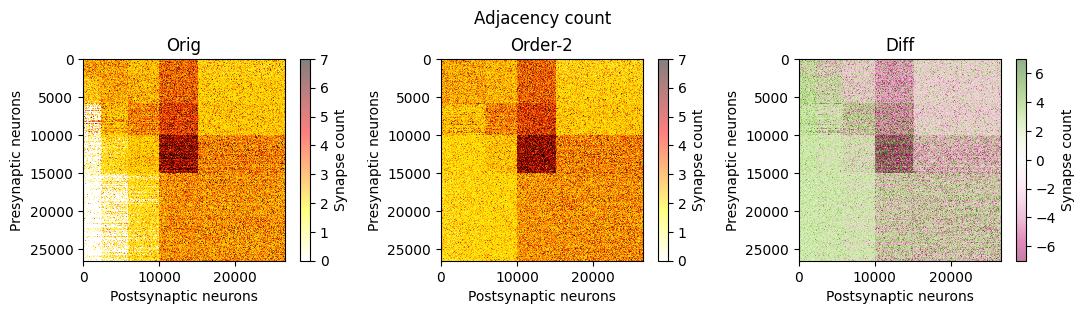

In [7]:
# Load config & run 2nd-order comparison
structcomp_config = load_config_from_file(config_paths[-1], 'structcomp_config__O1v5-SONATA__Orig_vs_Order-2.json')
structural_comparator.main(structcomp_config, show_fig=True, force_recomp=[False, False])

INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA/sonata/circuit_config_tmp.json
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA__ConnRewireOrder3mc2EE100pct/circuit_config.json
INFO: Preparing "ConnPerLayer_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_ConnPerLayer_mc2EE.pickle
INFO: Computing connectivity (group_by=layer, sel_src={'hypercolumn': 2, 'synapse_class': 'EXC'}, sel_dest={'hypercolumn': 2, 'synapse_class': 'EXC'}, N=6x6 groups)


100% |########################################################################|


INFO: Writing resutls to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-3_ConnPerLayer_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-3/struct_comp-ConnPerLayer_mc2EE-nsyn_conn.png...


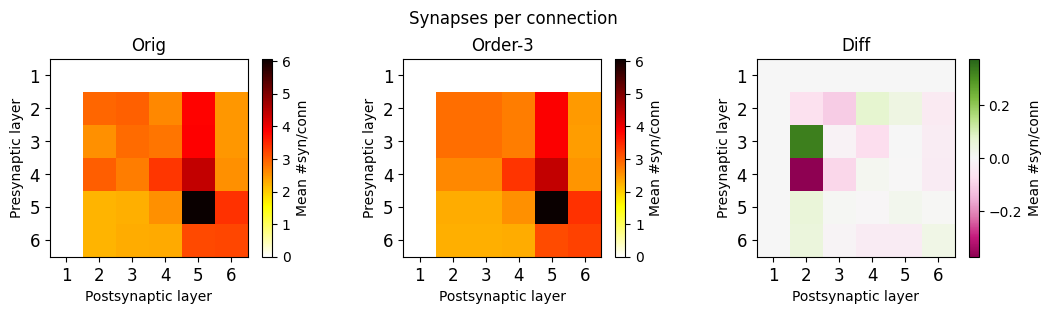

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-3/struct_comp-ConnPerLayer_mc2EE-conn_prob.png...


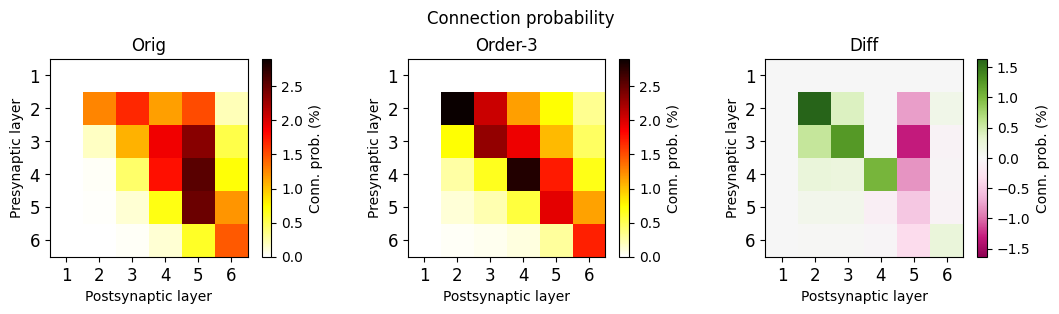

INFO: Preparing "ConnPerMtype_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_ConnPerMtype_mc2EE.pickle
INFO: Computing connectivity (group_by=mtype, sel_src={'hypercolumn': 2, 'synapse_class': 'EXC'}, sel_dest={'hypercolumn': 2, 'synapse_class': 'EXC'}, N=13x13 groups)


100% |########################################################################|


INFO: Writing resutls to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-3_ConnPerMtype_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-3/struct_comp-ConnPerMtype_mc2EE-nsyn_conn.png...


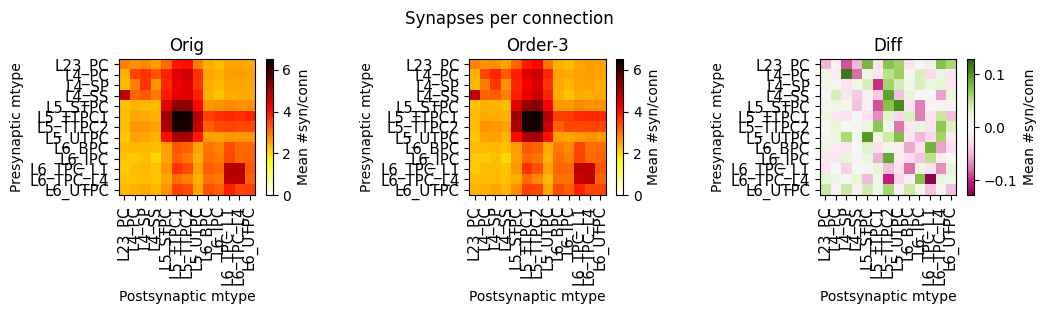

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-3/struct_comp-ConnPerMtype_mc2EE-conn_prob.png...


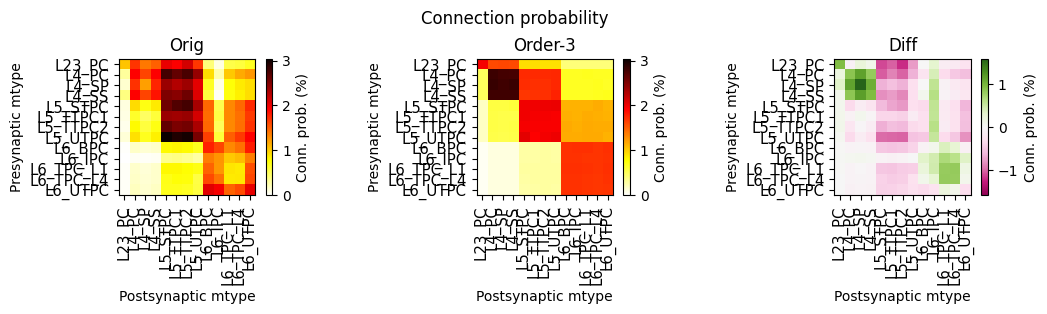

INFO: Preparing "PropsPerLayer_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_PropsPerLayer_mc2EE.pickle
INFO: Extracting synapse properties (group_by=layer, sel_src={'hypercolumn': 2, 'synapse_class': 'EXC'}, sel_dest={'hypercolumn': 2, 'synapse_class': 'EXC'}, N=6x6 groups, per_conn=False)
INFO: Available synapse properties: 
['@source_node', '@target_node', 'absolute_efficacy', 'afferent_center_x', 'afferent_center_y', 'afferent_center_z', 'afferent_section_id', 'afferent_section_type', 'afferent_segment_id', 'afferent_segment_offset', 'conductance', 'decay_time', 'delay', 'depression_time', 'efferent_morphology_id', 'efferent_section_id', 'efferent_segment_id', 'efferent_segment_offset', 'facilitation_time', 'morpho_branch_order_axon', 'morpho_branch_order_dend', 'n_rrp_vesicles', 'nrn_line', 'syn_type_id', 'u_syn']


100% |########################################################################|


INFO: Writing resutls to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-3_PropsPerLayer_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-3/struct_comp-PropsPerLayer_mc2EE-conductance.png...


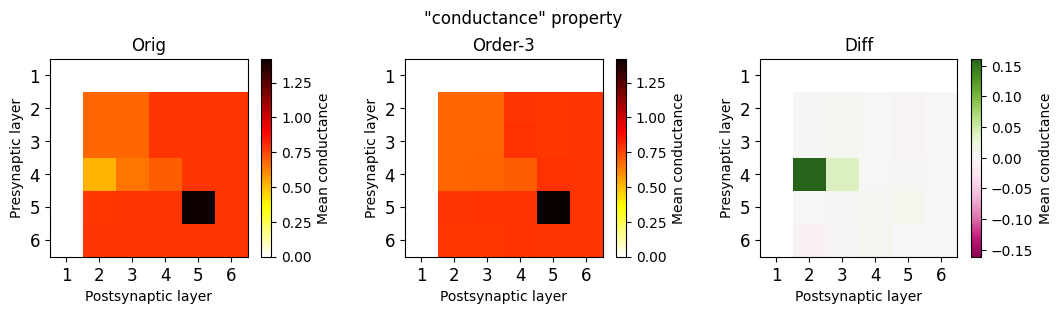

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-3/struct_comp-PropsPerLayer_mc2EE-delay.png...


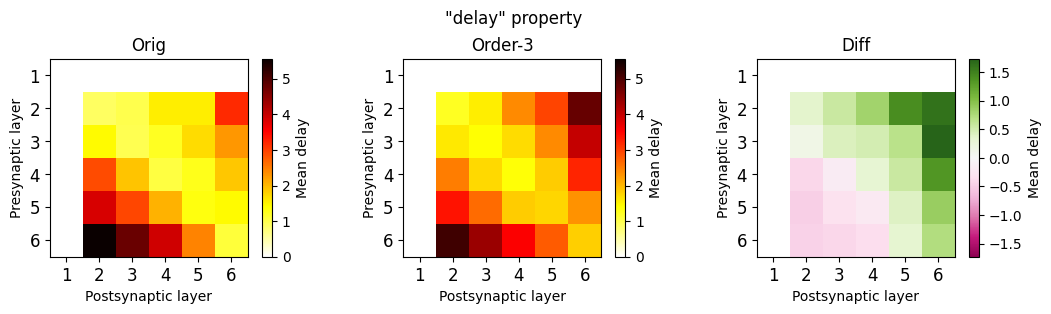

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-3/struct_comp-PropsPerLayer_mc2EE-u_syn.png...


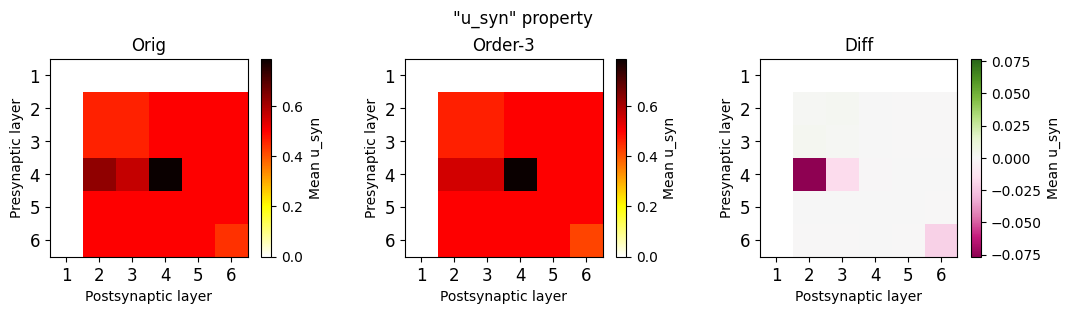

INFO: Preparing "PropsPerMtype_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_PropsPerMtype_mc2EE.pickle
INFO: Extracting synapse properties (group_by=mtype, sel_src={'hypercolumn': 2, 'synapse_class': 'EXC'}, sel_dest={'hypercolumn': 2, 'synapse_class': 'EXC'}, N=13x13 groups, per_conn=False)
INFO: Available synapse properties: 
['@source_node', '@target_node', 'absolute_efficacy', 'afferent_center_x', 'afferent_center_y', 'afferent_center_z', 'afferent_section_id', 'afferent_section_type', 'afferent_segment_id', 'afferent_segment_offset', 'conductance', 'decay_time', 'delay', 'depression_time', 'efferent_morphology_id', 'efferent_section_id', 'efferent_segment_id', 'efferent_segment_offset', 'facilitation_time', 'morpho_branch_order_axon', 'morpho_branch_order_dend', 'n_rrp_vesicles', 'nrn_line', 'syn_type_id', 'u_syn']


100% |########################################################################|


INFO: Writing resutls to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-3_PropsPerMtype_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-3/struct_comp-PropsPerMtype_mc2EE-conductance.png...


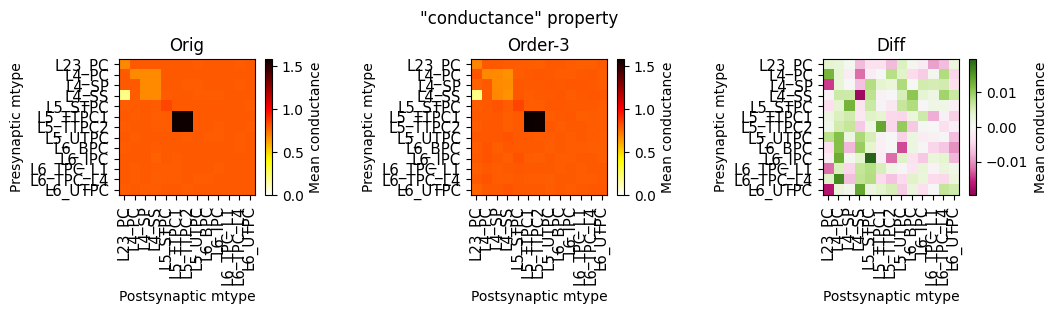

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-3/struct_comp-PropsPerMtype_mc2EE-delay.png...


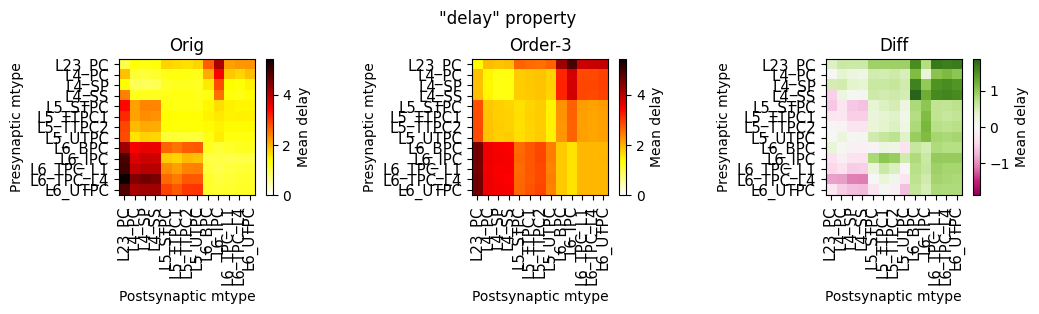

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-3/struct_comp-PropsPerMtype_mc2EE-u_syn.png...


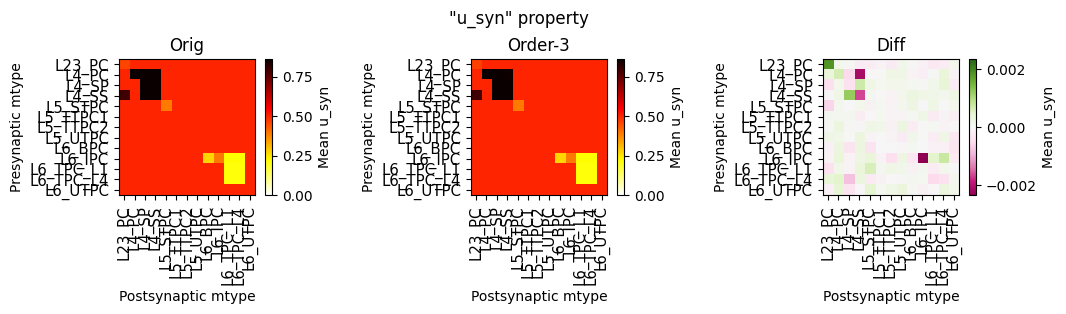

INFO: Preparing "Adjacency_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Orig_Adjacency_mc2EE.pickle
INFO: Creating 26567x26567 adjacency matrix (sel_src={'hypercolumn': 2, 'synapse_class': 'EXC'}, sel_dest={'hypercolumn': 2, 'synapse_class': 'EXC'})
INFO: Writing resutls to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/data/Order-3_Adjacency_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-3/struct_comp-Adjacency_mc2EE-adj.png...


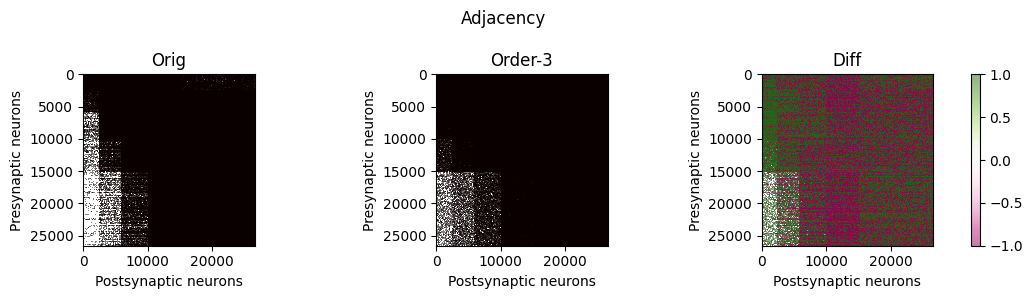

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA/Orig_vs_Order-3/struct_comp-Adjacency_mc2EE-adj_cnt.png...


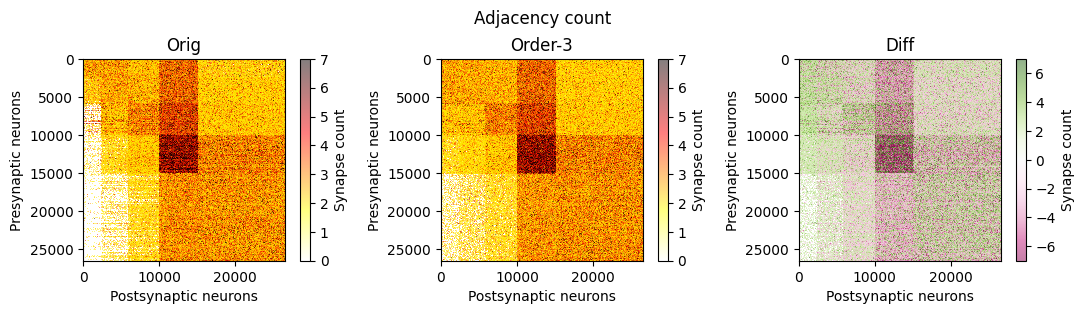

In [8]:
# Load config & run 3rd-order comparison
structcomp_config = load_config_from_file(config_paths[-1], 'structcomp_config__O1v5-SONATA__Orig_vs_Order-3.json')
structural_comparator.main(structcomp_config, show_fig=True, force_recomp=[False, False])

---
### Special cases for validation purposes

INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA/sonata/circuit_config_tmp.json
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA__ConnRewireOrder1mc2EE100pct/circuit_config.json
INFO: Preparing "ConnPerHypercolumn_EE" plot(s)...
INFO: Computing connectivity (group_by=hypercolumn, sel_src={'synapse_class': 'EXC'}, sel_dest={'synapse_class': 'EXC'}, N=7x7 groups)


100% |########################################################################|


INFO: Writing resutls to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA__AllMCs/data/Orig_ConnPerHypercolumn_EE.pickle
INFO: Computing connectivity (group_by=hypercolumn, sel_src={'synapse_class': 'EXC'}, sel_dest={'synapse_class': 'EXC'}, N=7x7 groups)


100% |########################################################################|


INFO: Writing resutls to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA__AllMCs/data/Order-1_ConnPerHypercolumn_EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA__AllMCs/Orig_vs_Order-1/struct_comp-ConnPerHypercolumn_EE-nsyn_conn.png...


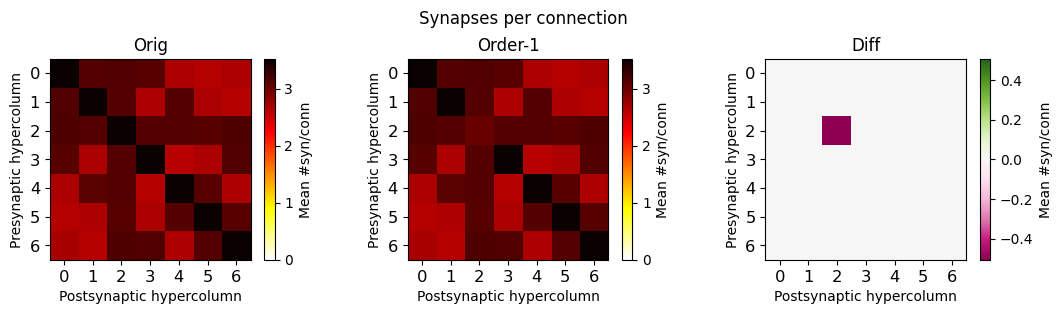

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA__AllMCs/Orig_vs_Order-1/struct_comp-ConnPerHypercolumn_EE-conn_prob.png...


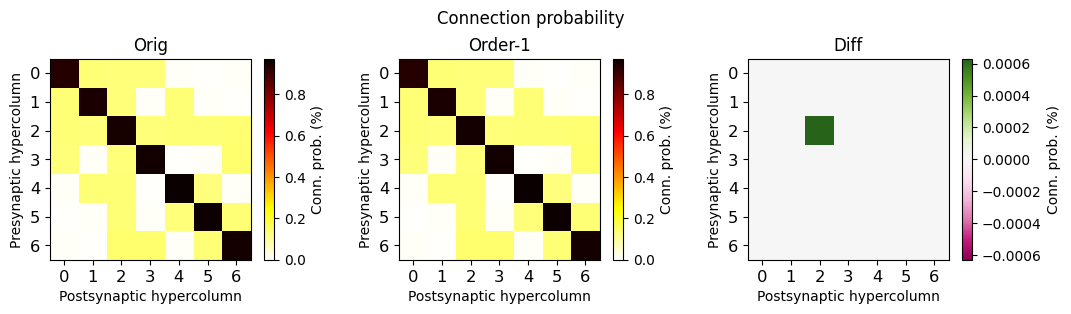

In [17]:
# Load config & run 1st-order comparison of all MCs
structcomp_config = load_config_from_file(config_paths[-1], 'structcomp_config__O1v5-SONATA__AllMCs__Orig_vs_Order-1.json')
structural_comparator.main(structcomp_config, show_fig=True, force_recomp=[False, False])

INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA/sonata/circuit_config_tmp.json
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA__ConnRewireOrder1mc2EE100pct/circuit_config.json
INFO: Preparing "ConnPerMtype_mc2" plot(s)...
INFO: Computing connectivity (group_by=mtype, sel_src={'hypercolumn': 2}, sel_dest={'hypercolumn': 2}, N=55x55 groups)


100% |########################################################################|


INFO: Writing resutls to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA__AllMtypes/data/Orig_ConnPerMtype_mc2.pickle
INFO: Computing connectivity (group_by=mtype, sel_src={'hypercolumn': 2}, sel_dest={'hypercolumn': 2}, N=55x55 groups)


100% |########################################################################|


INFO: Writing resutls to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA__AllMtypes/data/Order-1_ConnPerMtype_mc2.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA__AllMtypes/Orig_vs_Order-1/struct_comp-ConnPerMtype_mc2-nsyn_conn.png...


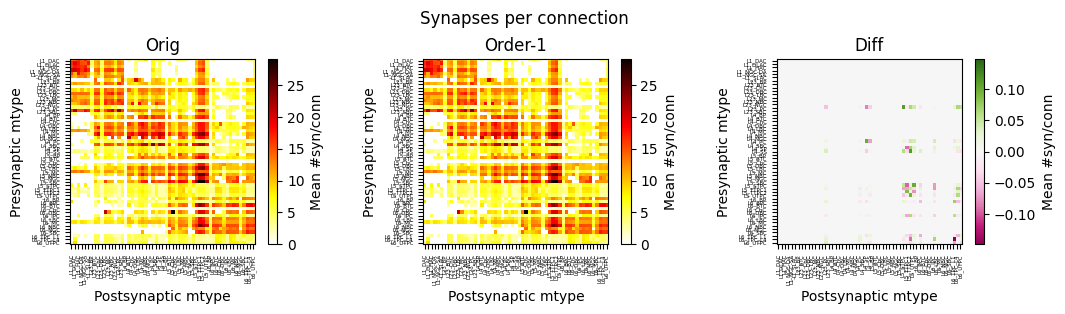

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/struct_comparison/O1v5-SONATA__AllMtypes/Orig_vs_Order-1/struct_comp-ConnPerMtype_mc2-conn_prob.png...


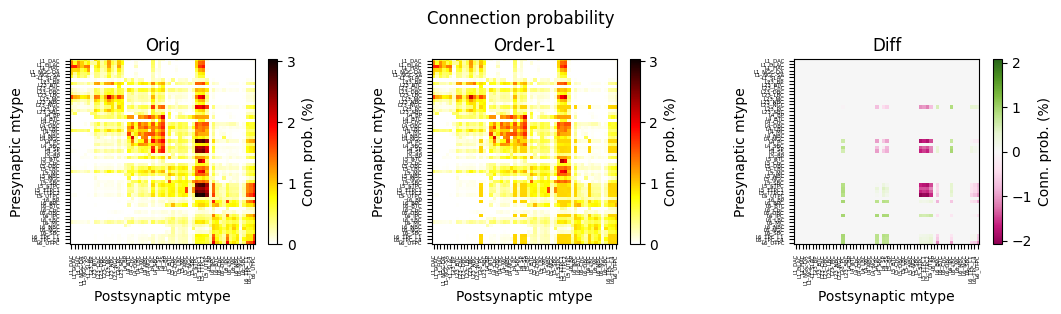

In [24]:
# Load config & run 1st-order comparison of all m-types (EXC + INH)
structcomp_config = load_config_from_file(config_paths[-1], 'structcomp_config__O1v5-SONATA__AllMtypes__Orig_vs_Order-1.json')
structural_comparator.main(structcomp_config, show_fig=True, force_recomp=[False, False])